### Double check that you've exported your transaction history from Presto Online!
Should be a `csv` file starting with `'THR'`

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
try:
    foo = str(list(Path('.').glob('THR_*.csv'))[0])
except IndexError:
    print("YOU DIDN'T GET THE CSV FILE!\nTHIS INCIDENT WILL BE REPORTED! (╯°□°）╯︵ ┻━┻\n\n\n\n\n\n")
df = pd.read_csv(foo).drop('Location', axis=1)
df.head(3)

,Date,Transit Agency,Type,Service Class,Discount,Amount,Balance
0,12/27/2018 3:02:07 PM,Toronto Transit Commission,Transfer,Regular,$0.00,$0.00,$0.00
1,12/27/2018 2:41:27 PM,Toronto Transit Commission,Fare Payment,Regular,$0.00,$3.00,$25.98
2,12/24/2018 4:09:31 PM,Toronto Transit Commission,Fare Payment,Regular,$0.00,$3.00,$28.98


In [3]:
# filthy recasting
df['Date'] = df['Date'].astype('datetime64')
df['Year'] = df['Date'].dt.year
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['Month'] = pd.Categorical(df['Date'].dt.strftime('%b'), categories=months, ordered=True)
df['Day'] = df['Date'].dt.day
df['Amount'] = df['Amount'].str.replace('$','').str.replace(')','').str.replace('(','-').astype(float)
df['Discount'] = df['Discount'].str.replace('$','').str.replace(')','').str.replace('(','-').astype(float)
df['Balance'] = df['Balance'].str.replace('$','').str.replace(')','').str.replace('(','-').astype(float)

In [4]:
df.sort_values(by='Date', inplace=True)

In [5]:
daily_transaction_counts = df.groupby([
    df.Year, df.Month, df.Day
])['Type '].count()
max_trans = daily_transaction_counts.idxmax()
max_trans_dt = pd.datetime.strptime('{}-{}-{}'.format(*max_trans), '%Y-%b-%d')

print(
    'The day with the highest number of transactions (total of '+
    f'{daily_transaction_counts[max_trans]}) was: {max_trans_dt.strftime("%A %B %d, %Y")}'
)

The day with the highest number of transactions (total of 6) was: Tuesday November 13, 2018


In [6]:
print('The transactions for that date:')
df.loc[
    df['Date'].dt.date == max_trans_dt.date()
]

The transactions for that date:


,Date,Transit Agency,Type,Service Class,Discount,Amount,Balance,Year,Month,Day
76,2018-11-13 08:49:11,Toronto Transit Commission,Fare Payment,Regular,0.0,3.0,2.98,2018,Nov,13
75,2018-11-13 08:59:48,Toronto Transit Commission,Payment By Credit,NaN,0.0,50.0,0.00,2018,Nov,13
74,2018-11-13 08:59:48,Toronto Transit Commission,Load Amount,NaN,0.0,50.0,52.98,2018,Nov,13
73,2018-11-13 12:11:55,Toronto Transit Commission,Fare Payment,Regular,0.0,3.0,49.98,2018,Nov,13
72,2018-11-13 14:39:15,Toronto Transit Commission,Fare Payment,Regular,0.0,3.0,46.98,2018,Nov,13
71,2018-11-13 17:56:29,Toronto Transit Commission,Fare Payment,Regular,0.0,3.0,43.98,2018,Nov,13


In [7]:
print('Fares paid using Presto card by year/month')
df.loc[
    df['Type '] == 'Fare Payment'
].groupby([
    'Year', 'Month'
])['Amount'].sum()

Fares paid using Presto card by year/month


Year  Month
2018  May       29.02
      Jul        3.00
      Aug        3.00
      Nov      129.00
      Dec       90.00
Name: Amount, dtype: float64

In [8]:
print('Dollar amount loaded to Presto card by year/month')
df.loc[
    df['Type '] == 'Load Amount'
].groupby([
    'Year', 'Month'
])['Amount'].sum()

Dollar amount loaded to Presto card by year/month


Year  Month
2018  Apr       10.0
      May       70.0
      Nov      100.0
      Dec      100.0
Name: Amount, dtype: float64

In [9]:
loaded = df.loc[df['Type '] == 'Load Amount', 'Amount'].sum()
spent = df.loc[df['Type '] == 'Fare Payment', 'Amount'].sum()

print(f'Total amount loaded to card: ${loaded:.2f}')
print(f'Total amount spent on fares: ${spent:.2f}')
print(f'Expected balance: ${loaded-spent:.2f}')
print(f'Actual balance: ${df.loc[df["Type "] != "Transfer"].iloc[-1].Balance:.2f}')

Total amount loaded to card: $280.00
Total amount spent on fares: $254.02
Expected balance: $25.98
Actual balance: $25.98


In [10]:
df.tail()

,Date,Transit Agency,Type,Service Class,Discount,Amount,Balance,Year,Month,Day
4,2018-12-21 17:51:22,Toronto Transit Commission,Transfer,Regular,0.0,0.0,0.00,2018,Dec,21
3,2018-12-24 08:05:25,Toronto Transit Commission,Fare Payment,Regular,0.0,3.0,31.98,2018,Dec,24
2,2018-12-24 16:09:31,Toronto Transit Commission,Fare Payment,Regular,0.0,3.0,28.98,2018,Dec,24
1,2018-12-27 14:41:27,Toronto Transit Commission,Fare Payment,Regular,0.0,3.0,25.98,2018,Dec,27
0,2018-12-27 15:02:07,Toronto Transit Commission,Transfer,Regular,0.0,0.0,0.00,2018,Dec,27


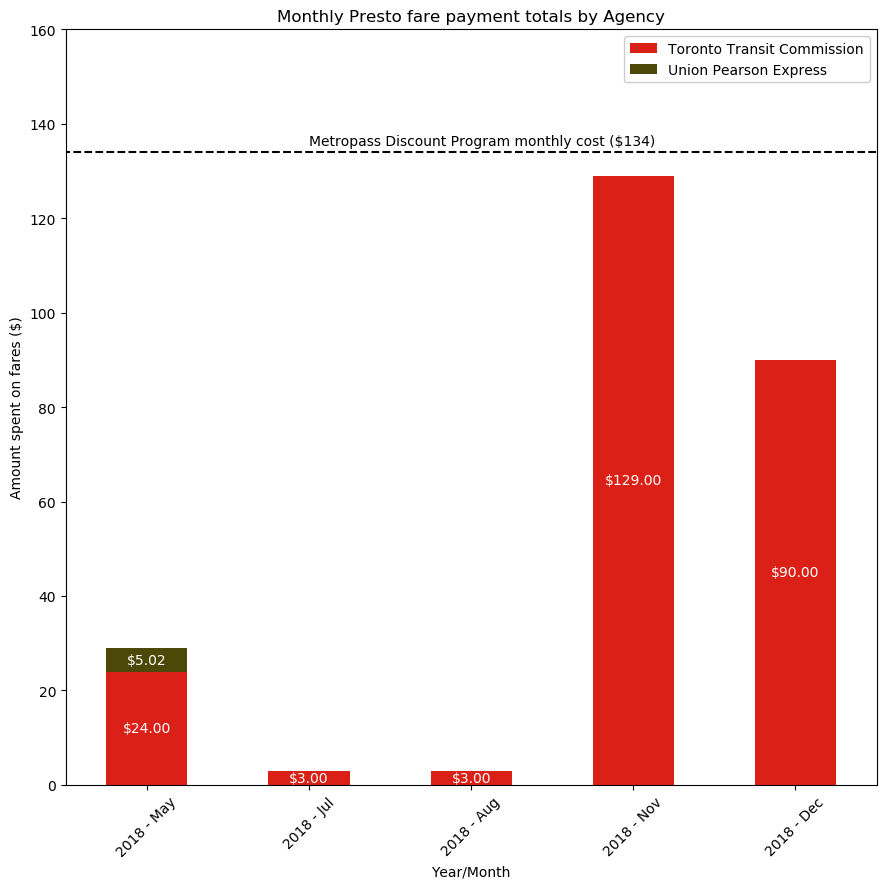

In [11]:
# order is important
agency_colors = [
    '#DB2017', # TTC deep red
    '#4C4807', # UPX forest green
]

# setup figure params
fig, ax = plt.subplots(figsize=(9,9), dpi=100)

# only want fare payment amounts, grouped by year/month/agency
plot_data = df.loc[
    df['Type '] == 'Fare Payment'
].groupby([
    'Year', 'Month', 'Transit Agency'
])['Amount'].sum().unstack('Transit Agency')

# plot stacked vertical bar
plot_data.plot(kind='bar', ax=ax, label='', color=agency_colors, stacked=True)

# add horizontal line to show where the MDP cost cutoff is
ax.hlines(
    y=134, 
    xmin=-1, 
    xmax=len(plot_data), 
    label = None, 
    linestyles='dashed'
)
ax.annotate(
    'Metropass Discount Program monthly cost ($134)',
    (1, 135.5)
)

# add $ values for bar components
# thanks Tom A. : https://stackoverflow.com/a/25449186
# thanks xg.plt.py : https://stackoverflow.com/a/50161387
for p in ax.patches:
    if p.get_height() != 0:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(
            '${:.2f}'.format(height), 
            (x + width * 0.5, y + height * 0.5),
            ha='center',
            va='center',
            color='white'
        )

# plot formatting
ax.set_title('Monthly Presto fare payment totals by Agency')
ax.set_xticklabels(
    ['%s - %s' % pair for pair in plot_data.index.tolist()],
    rotation = 45
)
ax.set_ylabel('Amount spent on fares ($)')
ax.set_xlabel('Year/Month')
ax.set_ylim(top=160)
ax.legend(framealpha=1)
fig.tight_layout();